# Predicting Number of Oscar Nominations for a Movie

Topic | Date | Name
-----|------|-----
Explore boxofficemojo data |04/14/2016 |Max Melnick

In [ ]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import pickle

import requests
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime
from time import strftime
from math import ceil
from scipy import stats
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

from matplotlib.ticker import FuncFormatter

%matplotlib inline

import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool

import dateutil.parser

from math import ceil

import omdb
omdb.set_default('tomatoes', True)
omdb.set_default('media_type', 'movie')

from collections import defaultdict

import string

In [2]:
base_url = 'http://www.boxofficemojo.com'
nan = np.nan

### Define utility and scraping functions

In [4]:
import time

def timefunc(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print f.__name__, 'took', end - start, 'seconds'
        return result
    return f_timer

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)

formatter = FuncFormatter(millions)

def urlToSoup(url):
    response = requests.get(url)
    return BeautifulSoup(response.text, 'lxml')

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def money_to_int(moneystring):
    try:
        moneystring = moneystring.replace(' (Estimate)', '')
        moneystring = moneystring.replace('$', '').replace(',', '')
        return int(moneystring)
    except:
        return None

def runtime_to_minutes(runtimestring):
    try:
        runtime = runtimestring.split()
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def budgetToInt(budget_string):
    if not budget_string:
        return None
    
    budget_list = budget_string.replace('$','').split(' ')
    # when the movie budget is a string in form $XX million
    if len(budget_list) > 1:
        budget = int(float(budget_list[0])*1000000)
        return budget
    # when budget is a string like $100,000
    elif budget_list[0].lower() != 'n/a':
        budget = budget_list[0].replace(',','')
        return money_to_int(budget)
    # when budget is a string == 'N/A' or not listed
    else:
        return None

def getNumTheaters(raw_theater_string):
    theater_string = str(raw_theater_string)
    theater_string = re.search('(\d+,?\d+)+ theaters', theater_string)
    if theater_string:
        theater_string = theater_string.group(0).replace(',','').split(' ')
        return int(theater_string[0])
    else:
        return None
        

def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    in_box_content = obj.find_parents(class_='mp_box_content')
    if in_box_content:
        return getBoxContent(obj)
    else:
        return getHeadTableContent(obj)
    

def getHeadTableContent(obj):
    next_sibling = obj.findNextSibling()
    parent_sibling = obj.find_parent().findNextSibling()
    if next_sibling:
        return next_sibling.text 
    elif parent_sibling:
        return parent_sibling.text
    else:
        return None
    
def getBoxContent(obj):
    next_td = obj.find_parent('td').find_next_sibling('td')
    if next_td:
        return next_td.get_text(strip=True)
    else:
        return getNumTheaters(obj)
    
def parseTitle(title_string):
    return title_string.split('(2')[0].strip()

def getSingleMovieData(soup_and_url):
    url = soup_and_url['url']
    soup = soup_and_url['soup']
    
    #create a blank dictionary that will be used to track the movie data
    movie_data = {}
    
    movie_data['url'] = url
    
    #get the movie director and add it to `movie_data` dictionary
    movie_data['director'] = get_movie_value(soup, 'Director')
    
    #get the movie title
    try:
        title_string = soup.find('title').text
        movie_data['title'] = parseTitle(title_string)
    except:
        print 'issue parsing movie title for ', url
    
    #get the release date
    raw_release_date = get_movie_value(soup,'Release Date')
    try: 
        movie_data['release_date'] = to_date(raw_release_date)
    except:
        print ('issues parsing release date for this url', url)
    
    #get the domestic total gross
    raw_domestic_total_gross = get_movie_value(soup,'Domestic Total')
    movie_data['domestic_total_gross'] = money_to_int(raw_domestic_total_gross)
    
    # foreign gross
    movie_data['foreign_total_gross'] = money_to_int(get_movie_value(soup, 'Foreign:'))
    
    #get the MPAA rating
    movie_data['rating'] = get_movie_value(soup,'MPAA Rating')
    
    # get runtime and convert it to an int
    raw_runtime = get_movie_value(soup,'Runtime')
    movie_data['runtime'] = runtime_to_minutes(raw_runtime)
    
    # get genre
    movie_data['genre'] = get_movie_value(soup,'Genre:')

    # get production budget
    raw_budget = get_movie_value(soup,'Production Budget')    
    movie_data['budget'] = budgetToInt(raw_budget)
    
    # opening weekend
    movie_data['opening_weekend_gross'] = money_to_int(get_movie_value(soup, 'Weekend:'))
    
    # studio
    movie_data['studio'] = get_movie_value(soup, 'Distributor:')
    
    # num opening weekend theaters
    movie_data['num_opening_theaters'] = get_movie_value(soup, 'theaters,')
    
    return movie_data

def getHrefFromATags(a_tag_list):
    ignore_links = set([''])
    links = []
    for link in a_tag_list:
        full_link = base_url+link.get('href')
        links.append(full_link)
    
    return links

def getMovieLinks(year_list):
    #generate the urls that we'll scrape for each year on boxofficemojo.com
    year_urls = []
    for year in year_list:
        top_hundred_url = 'http://www.boxofficemojo.com/yearly/chart/?yr='+year+'&p=.htm'
        year_urls.append(top_hundred_url)
        year_urls += getMoreLinksForOneYear(top_hundred_url)
        
    links_to_movies = []
    for url in year_urls:
        links_to_movies += urlToSoup(url).find(id='body').find_all('a', href=re.compile('^/movies/\?id'))
    
    links = getHrefFromATags(links_to_movies)
    return links

def getMoreLinksForOneYear(url):
    top_hundreds = urlToSoup(url).find('center').find_all('a', href=re.compile('^/yearly/chart/'))
    return getHrefFromATags(top_hundreds)

@timefunc
def getAllMovieDataSlow(year_list):
    links_to_movies = getMovieLinks(year_list)

    data = []
    for url in links_to_movies:
        soup = urlToSoup(url)
        movie_data = getSingleMovieData({'url': url, 'soup': soup})
        data.append(movie_data)
    return DataFrame(data)

def fetchSoup(url):
    soup = urlToSoup(url)
    # some urls we collect are broken. Check if they're broken and filter them out if they are
    checkInvalidUrl = soup.find('center', text=re.compile('Invalid Movie ID Specified.'))
    if not checkInvalidUrl:
        return {'url': url, 'soup': soup}
    else:
        return None

def getMovieSoups(urls):
    pool = Pool(25)
    soup_and_urls = []
    for url in urls:
        soup_and_url = pool.spawn(fetchSoup, url)
        soup_and_urls.append(soup_and_url)
    pool.join()
    return soup_and_urls

@timefunc
def getAllMovieData(year_list):
    links_to_movies = getMovieLinks(year_list)
    
    movie_soups = getMovieSoups(links_to_movies)
    
    data = []
    for movie_soup in movie_soups:
        val = movie_soup.value
        if val:
            movie_data = getSingleMovieData(val)
            data.append(movie_data)
    return DataFrame(data)

In [ ]:
#list the years that we want to get data for the top 100 movies of each year
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', 
         '2009', '2010', '2011', '2012', '2013','2014','2015']

I separate the years into groups of two in order to break up the web scraping as my computer was having some memory issues handling all 16 years at a time.

In [7]:
step = 2
years_separated = [years[i:i+step] for i in range(0, len(years), step)]
print years_separated

[['2000', '2001'], ['2002', '2003'], ['2004', '2005'], ['2006', '2007'], ['2008', '2009'], ['2010', '2011'], ['2012', '2013'], ['2014', '2015']]


In [471]:
movie_dfs = []
for year_list in years_separated:
    movie_dfs.append(getAllMovieData(year_list))

getAllMovieData took 46.7253000736 seconds
getAllMovieData took 67.0824711323 seconds
('issues parsing release date for this url', 'http://boxofficemojo.com/movies/?id=mymotherlikeswomen.htm')
('issues parsing release date for this url', 'http://boxofficemojo.com/movies/?id=freestyle.htm')
getAllMovieData took 72.9689240456 seconds
getAllMovieData took 81.9299149513 seconds
getAllMovieData took 74.9416439533 seconds
getAllMovieData took 76.2961788177 seconds
getAllMovieData took 86.6097829342 seconds
('issues parsing release date for this url', 'http://boxofficemojo.com/movies/?id=court\x0b.htm')
getAllMovieData took 91.7662880421 seconds


In [543]:
movie_df = pd.concat(movie_dfs)

# remove movies we were "Unable to Process"
movie_df = movie_df.query('title != "Unable to Process"')

In [596]:
# certain links don't work correctly. Let's remove those
set_to_remove = set(['http://www.boxofficemojo.com/movies/?id=nbc3d09.htm',\
                     'http://www.boxofficemojo.com/movies/?id=stolen2010.htm',\
                     'http://www.boxofficemojo.com/movies/?id=home09.htm', \
                     'http://www.boxofficemojo.com/movies/?id=metropolis2010reissue.htm', \
                     'http://www.boxofficemojo.com/movies/?id=polarexpress2011reissue.htm'])

movie_df = movie_df.query('url not in @set_to_remove')

The following lines are commented out but were used to write/read the movie data to a pickle file so I didn't have to re-run the scraping everytime I restarted my Jupyter notebook

In [8]:
# movie_df.to_pickle('movie_df.pickle')
# movie_df = pd.read_pickle('movie_df.pickle')

### Remove duplicate movies

In [9]:
def removeDuplicates(df):
    new_df = df[df.duplicated(subset=['title'], keep=False)].sort_values(by='title')
    
    # make sure there's no > 2 duplicate titles
    assert new_df.groupby('title')['url'].count().sort_values(ascending=False).max() < 3
    
    rows_to_delete = []
    low_bound = 0
    up_bound = 2
    step = 2
    # loop through all rows, two at a time and get index of movie with lower domestic gross (so we can remove it)
    while up_bound <= len(new_df):
        rows = new_df[low_bound:up_bound]
        dtgs = rows['domestic_total_gross']
        rows_to_delete.append(dtgs.idxmin())
            
        low_bound += step
        up_bound += step
    
    deduped_df = df.drop(rows_to_delete)
    
    return deduped_df, rows_to_delete

In [10]:
deduped_df, rows_to_delete = removeDuplicates(movie_df)

In [11]:
len(rows_to_delete)

115

### Add Oscar Data

In [13]:
def parseOscarTable(soup):
    table = soup.find('table', bgcolor='#e6ado2')
    table_rows = table.find_all('tr')
    #get rid of the header row
    table_rows.pop(0)
    data = []
    for row in table_rows:
        oscar_data = {}
        columns = row.find_all('td')
        oscar_data['title'] = parseTitle(columns[2].get_text(strip=True))
        oscar_data['noms'] = columns[5].get_text(strip=True)
        oscar_data['wins'] = columns[6].get_text(strip=True)
        data.append(oscar_data)
    return data

# return a DataFrame with Oscar nominations and wins by movie
def getOscarData(year_list):
    year_urls = []
    for year in year_list:
        year_urls.append('http://www.boxofficemojo.com/oscar/chart/?view=allmovies&yr='+year+'&p=.htm')
    
    oscar_data = []
    for url in year_urls:
        soup = urlToSoup(url)
        oscar_data += parseOscarTable(soup)
        
    return DataFrame(oscar_data)

In [14]:
oscar_df = getOscarData(years)

In [15]:
oscar_df.head()

,noms,title,wins
0,12,Gladiator,5
1,10,"Crouching Tiger, Hidden Dragon",4
2,5,Traffic,4
3,5,Erin Brockovich,1
4,4,Almost Famous,1


In [16]:
df = deduped_df.merge(oscar_df, on='title', how='left')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8345 entries, 0 to 8344
Data columns (total 15 columns):
budget                   2127 non-null float64
director                 2754 non-null object
domestic_total_gross     8345 non-null float64
foreign_total_gross      4191 non-null float64
genre                    8345 non-null object
num_opening_theaters     3737 non-null float64
opening_weekend_gross    7937 non-null float64
rating                   8345 non-null object
release_date             8345 non-null datetime64[ns]
runtime                  8046 non-null float64
studio                   8345 non-null object
title                    8345 non-null object
url                      8345 non-null object
noms                     587 non-null object
wins                     587 non-null object
dtypes: datetime64[ns](1), float64(6), object(8)
memory usage: 1.0+ MB


### Add rating data from [OMDB](http://omdbapi.com/)

In [18]:
def convertString(my_string, *movie):
    '''
    Convert a string column so that it can easily be compared to another.
    For example, case and punctuation should not matter
    '''
    
    # certain titles in BoxOfficeMojo don't match OMDB movie titles so we'll define explicit
    # mappings for some of them to improve our matching
    string_replacements = {
        '20 Feet from Stardom': 'Twenty Feet From Stardom',
        "Marvel's The Avengers": 'The Avengers',
        'Jackass Presents: Bad Grandpa': 'Bad Grandpa',
        'Precious: Based on the Novel "Push" by Sapphire': 'Precious',
        'Frost/Nixon': 'Frost/Nixon',
        'Lemony Snicket\'s A Series of Unfortunate Events': 'A Series of Unfortunate Events',
        '3:10 to Yuma': '3:10 to Yuma',
        'Tim Burton\'s Corpse Bride': 'Corpse Bride',
        'X2: X-Men United': 'X-Men 2',
        'Dr. Seuss\' The Lorax': 'The Lorax',
        'Dr. Seuss\' Horton Hears a Who!': 'Horton Hears a Who!',
        'Fahrenheit 9/11': 'Fahrenheit 9/11',
        'Spy Kids 2: The Island of Lost Dreams': 'Spy Kids 2: Island of Lost Dreams',
        'Maze Runner: The Scorch Trials': 'The Scorch Trials',
        'Garfield: The Movie': 'Garfield',
        'National Lampoon\'s Van Wilder': 'Van Wilder: Party Liaison'
    }
    if my_string in string_replacements.keys():
        return string_replacements[my_string]
    else:
        new_string = my_string.replace('Tyler Perry\'s ', '')
        new_string = new_string.lower()
        new_string = new_string.replace('3-d', '3d')
        new_string = re.sub("(\S)-(\S)", '\\1 \\2', new_string)
        new_string = re.sub("\sand\s", ' ', new_string)
        return re.sub("[^a-zA-Z\d\s']", '', new_string).replace('  ', ' ')
    
def getOMDBMovie(movie, *year_adj):
    '''
    
    '''
    bomj_title = movie['title']
    release_date = movie['release_date']
    
    if not year_adj:
        year_adj = 0
    else:
        year_adj = int(year_adj[0])
    
    year = release_date.year
    title_to_search = convertString(bomj_title, movie)
    res = omdb.search(title_to_search, year=(year+year_adj))
    if res:
        movie = omdb.title(res[0].title)
        data = movie.items()
        if data:
            data.append(('bomj_title', bomj_title))
            return dict(data)
        else:
            return movie
    else:
        return movie
    
def getOMDBDataForTitle(movie):
    '''
    Given a movie get the corresponding data from OMDB. 
    If no data is found on OMDB, return the movie title we were searching for
    '''
    counter = 0
    year_adj = [0,1,-1]
    while counter < 3:
        data = getOMDBMovie(movie, year_adj[counter])
        if 'bomj_title' in data.keys():
            return data
        counter += 1
    
    return movie

def getRawOMDBData(movies):
    '''
    Take a dataframe of movie data and return a list of data from OMDB for each movie
    '''
    #movies = movies.query('release_date >= "2010-01-01"')
    movie_records = movies.to_dict(orient='records')
    pool = Pool(25)
    data = []
    for movie in movie_records:
        data.append(pool.spawn(getOMDBDataForTitle, movie))
    pool.join()
    return data

def separateData(raw_movie_data):
    '''
    take the raw movie data returned by OMDB and separate it out into two lists:
    one with the movies that had no OMDB matches, and another with the data where
    OMDB did have data
    '''
    data = []
    no_match = []
    for movie in raw_movie_data:
        val = movie.value
        if 'bomj_title' in val.keys():
            data.append(val)
        else:
            no_match.append(val)
    
    movie_df = DataFrame(data)
    
    movie_df.rename(columns={'title':'omdb_title'}, inplace=True)
    
    hard_match_df = movie_df[movie_df['bomj_title'].map(convertString) == movie_df['omdb_title'].map(convertString)]
    
    soft_match_df = movie_df[~movie_df.isin(hard_match_df)].dropna()
    
    return hard_match_df, soft_match_df, DataFrame(no_match), movie_df

@timefunc
def getOMDBData(movies):
    hard_matches_list = []
    soft_matches_list = []
    no_matches_list = []
    
    raw_movie_data = getRawOMDBData(movies)
    
    hard_matches, soft_matches, no_matches, movie_df = separateData(raw_movie_data)
    
    hard_matches = hard_matches.replace({'N/A': nan})
    
    return hard_matches, soft_matches, no_matches, movie_df

In [19]:
omdb_hard_matches, omdb_soft_matches, omdb_no_matches, movie_df = getOMDBData(df)

print 'number of hard_matches', len(omdb_hard_matches)
print 'number of soft_matches', len(omdb_soft_matches)
print 'number of no_matches', len(omdb_no_matches)

total_movies = len(omdb_hard_matches) + len(omdb_soft_matches) + len(omdb_no_matches)

print 'total_movies', total_movies

assert total_movies == len(df)

getOMDBData took 71.8291559219 seconds
number iiof hard_matches 6134
number of soft_matches 1067
number of no_matches 1144
total_movies 8345


Take a look at movies that we couldn't get matches in OMDB for

In [20]:
omdb_no_matches[['title','domestic_total_gross','noms','release_date']]\
    .sort_values(by=['noms','domestic_total_gross'], ascending=False).head(50)

,title,domestic_total_gross,noms,release_date
182,Winged Migration,10764402.0,1,2003-04-18
185,Nowhere in Africa,6180200.0,1,2003-03-07
801,Barney's Version (U.S. only),4439201.0,1,2011-01-14
739,A Prophet (Un prophète),2087720.0,1,2010-02-26
803,Incendies (U.S. only),2071334.0,1,2011-04-22
879,Monsieur Lazhar (U.S.-only),2009517.0,1,2012-04-13
368,Joyeux Noel (Merry Christmas),1054361.0,1,2005-12-16
1065,The 100-Year Old Man Who Climbed Out the Windo...,944193.0,1,2015-05-01
281,Twilight Samurai,559765.0,1,2004-04-23
880,Chico & Rita,350524.0,1,2012-02-10


What movies may we have found a match in OMDB, but the titles didn't exactly match?

In [21]:
omdb_soft_matches[['bomj_title','omdb_title','released','production','box_office']].head()

,bomj_title,omdb_title,released,production,box_office
15,The Nutty Professor II: The Klumps,Nutty Professor II: The Klumps,28 Jul 2000,Universal Pictures,$122.4M
21,Gone in 60 Seconds,Gone in 60 Seconds: The Ride,N/A,N/A,N/A
55,Pokemon: The Movie 2000,The Power of One: The Pokemon 2000 Movie Special,16 Jul 2000,N/A,N/A
138,Black and White,Black and White in Colour,25 Mar 2000,N/A,N/A
150,Malena,Malèna,02 Feb 2001,Miramax,N/A


In [22]:
full_df = df.merge(omdb_hard_matches, left_on='title', right_on='bomj_title', how='left', suffixes=['', '_omdb'])

Archive the current DataFrame we're working with to a pickle file so we can easily pick up here later if we close the Jupyter Notebook or the Kernel dies

In [26]:
full_df.to_pickle('fulldf.pickle')

### Develop linear regression model

Create some utility functions that will come in handy for transforming some of the movie data

In [ ]:
def convertDateToSeason(datetime_obj):
    '''
    takes a datetime object and returns the associated season as a string
    '''
    day_of_year = datetime_obj.timetuple().tm_yday
    
    # set the boundary dates (note: year doesn't matter much here since
    # we only care about the day of the year)
    spring_start_day = datetime(2015, 3, 20).timetuple().tm_yday
    summer_start_day = datetime(2015, 6, 21).timetuple().tm_yday
    fall_start_day = datetime(2015, 9, 22).timetuple().tm_yday
    winter_start_day = datetime(2015, 12, 15).timetuple().tm_yday
    
    # return season as a string based on day_of_year
    if (day_of_year >= spring_start_day) and (day_of_year < summer_start_day):
        return 'Spring'
    elif (day_of_year >= summer_start_day) and (day_of_year < fall_start_day):
        return 'Summer'
    elif (day_of_year >= fall_start_day) and (day_of_year < winter_start_day):
        return 'Fall'
    else:
        return 'Winter'
    
def normalizeGenre(genre):
    '''
    Given a genre, return it's normalized genre so we shorten the possibilities for genres
    '''
    genre_map = {
        "Foreign": "Foreign",
        "Documentary": "Documentary",
        "Drama": "Drama",
        "Comedy": "Comedy",
        "Unknown": "Unknown",
        "Animation": "Animation",
        "Horror": "Horror",
        "Thriller": "Thriller",
        "Action": "Action",
        "Romance": "Romance",
        "Fantasy": "Sci-Fi",
        "Sci-Fi": "Sci-Fi",
        "Musical": "Musical",
        "Family": "Family",
        "Historical Epic": "Action",
        "IMAX": "Unknown",
        "War Romance": "Drama",
        "Romantic Adventure": "Romance",
        "Period Adventure": "Action",
        "War": "Action",
        "Western": "Action",
        "Crime": "Drama",
        "Concert": "Musical",
        "Comedy / Drama": "Comedy",
        "Romantic Comedy": "Comedy",
        "Drama / Thriller": "Drama",
        "Crime Drama": "Drama",
        "Period Drama": "Drama",
        "Action Comedy": "Action",
        "Foreign / Action": "Foreign",
        "Family Comedy": "Family",
        "Action / Adventure": "Action",
        "Music Drama": "Drama",
        "Sports Drama": "Drama",
        "Family Adventure": "Family",
        "Horror Thriller": "Horror",
        "Action Thriller": "Action",
        "Horror Comedy": "Comedy",
        "Crime Comedy": "Comedy",
        "Crime Thriller": "Thriller",
        "Sci-Fi Action": "Sci-Fi",
        "Action Drama": "Action",
        "Historical Drama": "Drama",
        "Adventure": "Action",
        "Sports Comedy": "Comedy",
        "Fantasy Drama": "Drama",
        "Fantasy Comedy": "Comedy",
        "Sci-Fi Thriller": "Sci-Fi",
        "Action / Crime": "Action",
        "War Drama": "Drama",
        "Sci-Fi Horror": "Sci-Fi",
        "Action Horror": "Action",
        "Foreign / Horror": "Horror",
        "Sci-Fi Adventure": "Sci-Fi",
        "Sci-Fi Comedy": "Sci-Fi",
        "Romantic Thriller": "Thriller",
        "Comedy Thriller": "Comedy",
        "Adventure Comedy": "Comedy",
        "Period Comedy": "Comedy",
        "Period Action": "Action",
        "Sci-Fi Fantasy": "Sci-Fi",
        "Action Fantasy": "Action",
        "Period Horror": "Horror",
        "Western Comedy": "Comedy",
        "Sports Action": "Action"
    }
    
    return genre_map[genre]

Add a column `noms_y` that represents the total number of oscar nominations the movie director had received before the movie was released

In [ ]:
def addPrevDirectorNoms(df):
    '''
    
    '''
    director_prev_noms_df = df[['director','noms', 'release_date']].dropna(subset=['noms'])
    director_prev_noms_df['noms'] = director_prev_noms_df['noms'].astype('int')
    director_prev_noms_df = pd.merge(director_prev_noms_df, director_prev_noms_df, on='director')
    director_prev_noms_df = director_prev_noms_df[director_prev_noms_df['release_date_x']>director_prev_noms_df['release_date_y']]
    director_prev_noms_df = director_prev_noms_df.groupby(['director', 'noms_x', 'release_date_x'], as_index=False).sum()

    prev_noms = df.merge(director_prev_noms_df, left_on=['director', 'release_date'], right_on=['director', 'release_date_x'],\
                            how='left')
    
    prev_noms['prev_noms'] = prev_noms['noms_y'].fillna(0).astype(int)
    
    prev_noms = prev_noms.drop(['noms_y','noms_x'], 1)

    return prev_noms

In [100]:
def cleanAndTransformData(df):
    '''
    Take a dataframe and return a new dataframe with necessary cleaning and
    transformations to movie data.
    '''
    transformed_df = df
    
    transformed_df = addPrevDirectorNoms(transformed_df)
    
    # create new columns for nominations and fill NaN with 0
    transformed_df.loc[:, 'noms_adj'] = transformed_df.loc[:,'noms'].dropna().astype('int').apply(np.log)
    
    transformed_df = transformed_df.dropna(subset=['release_date', 'opening_weekend_gross',\
                                                   'tomato_user_meter',\
                                                   'metascore', 'noms_adj'], how='any')
    
    # convert our rating data to int
    #transformed_df.loc[:, 'tomato_meter'] = transformed_df.loc[:,'tomato_meter'].astype('int')
    transformed_df.loc[:, 'tomato_user_meter'] = transformed_df.loc[:,'tomato_user_meter'].astype('int')
    #transformed_df.loc[:, 'imdb_rating'] = transformed_df.loc[:,'imdb_rating'].astype('float')
    transformed_df.loc[:, 'metascore'] = transformed_df.loc[:,'metascore'].astype('int')
    
    # add season, then convert season from categorical to numeric columns and join back to df
    transformed_df.loc[:, 'season'] = transformed_df.loc[:,'release_date'].map(convertDateToSeason)
    season_dummies = pd.get_dummies(transformed_df['season'], prefix='season')
    # drop one of the dummy variables to avoid issues with multicolinearity
    season_dummies = season_dummies.drop(['season_Spring'], 1)
    transformed_df = transformed_df.join(season_dummies)
    
    # normalize genres, then convert from categorical to numeric columns and join back to df
    transformed_df.loc[:, 'genre_norm'] = transformed_df.loc[:,'genre'].map(normalizeGenre)
    genre_dummies = pd.get_dummies(transformed_df['genre_norm'], prefix='genre')
    # drop one of the dummy variables to avoid issues with multicolinearity
    genre_dummies = genre_dummies.drop(['genre_Comedy'], 1)
    transformed_df = transformed_df.join(genre_dummies)
    
    # normalize rating, then convert from categorical to numeric columns and join back to df
    rating_dummies = pd.get_dummies(transformed_df['rating'], prefix='rating')
    # drop one of the dummy variables to avoid issues with multicolinearity
    rating_dummies = rating_dummies.drop(['rating_G'], 1)
    transformed_df = transformed_df.join(rating_dummies)
    
    transformed_df['opening_weekend_gross'] = transformed_df['opening_weekend_gross'].apply(np.log)
    
    archived_df = transformed_df
    
    transformed_df = transformed_df.drop(['foreign_total_gross', 'num_opening_theaters',\
                                          'domestic_total_gross', 'runtime',\
                                         'budget'], 1)
    
    transformed_df = transformed_df.select_dtypes(include=['float64', 'int64'])
    
    return transformed_df, archived_df

In [149]:
def plotResiduals(Y_train, Y_test, pred_train, pred_test):
    print "Fit a model X_train, and calculate MSE with Y_train: %.2f"  % np.e**np.mean((Y_train - pred_train) ** 2)
    print "Fit a model X_train, and calculate MSE with X_test and Y_test: %.2f"  % np.e**np.mean((Y_test - pred_test) ** 2)
    # Scatter plot the training data
    train = plt.scatter(pred_train,(pred_train-Y_train),c='b',alpha=0.5)

    # Scatter plot the testing data
    test = plt.scatter(pred_test,(pred_test-Y_test),c='r',alpha=0.5)
    
    #Labels
    plt.legend((train,test),('Training','Test'),loc='lower left')
    plt.title('Residual Plots')

def runModel(X,y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y)
    print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
    model = sm.OLS(Y_train, X_train) 
    results = model.fit()
    # Predictions on training and testing sets
    pred_train = results.predict(X_train)
    pred_test = results.predict(X_test)
    
    mean = np.e**y.mean()
    print mean
    
    plotResiduals(Y_train, Y_test, pred_train, pred_test)
    
    test = X_test
    test['predicted_noms'] = np.e**pred_test
    
    return results, test

In [192]:
df_transformed, archived_df = cleanAndTransformData(full_df)

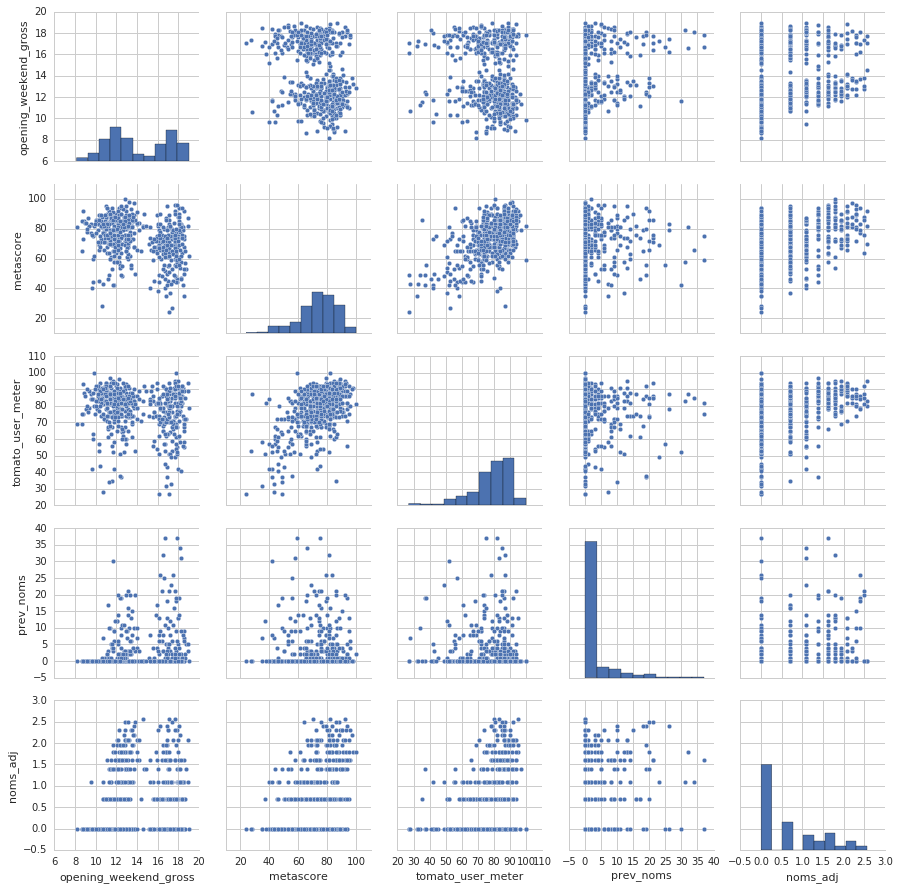

In [47]:
sns.pairplot(df_transformed, vars=['opening_weekend_gross', 'metascore', 'tomato_user_meter', 'prev_noms', 'noms_adj'])

(383, 24) (128, 24) (383,) (128,)
1.92906190908
Fit a model X_train, and calculate MSE with Y_train: 1.42
Fit a model X_train, and calculate MSE with X_test and Y_test: 1.53


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               noms_adj   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     11.57
Date:                Fri, 22 Apr 2016   Prob (F-statistic):           4.26e-31
Time:                        00:29:51   Log-Likelihood:                -342.88
No. Observations:                 383   AIC:                             733.8
Df Residuals:                     359   BIC:                             828.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
opening_weekend_gross     0.0555      0.017      3.241      0.001         0.022     0.089
metascore                 0.0220      0.003      7.045      0.000         0.016     0.028
tomato_user_meter         0.0084      0.003      2.741      0.006         0.002     0.014
prev_noms                 0.0224      0.006      3.644      0.000         0.010     0.035
season_Fall               0.3069      0.108      2.852      0.005         0.095     0.518
season_Summer             0.0236      0.113      0.209      0.835        -0.199     0.246
season_Winter             0.3410      0.114      2.996      0.003         0.117     0.565
genre_Action              0.2005      0.148      1.353      0.177        -0.091     0.492
genre_Animation          -0.6640      0.203     -3.267      0.001        -1.064    -0.264
genre_Documentary        -0.4536      0.177     -2.565      0.011        -0.802    -0.106
genre_Drama               0.2144      0.112      1.913      0.057        -0.006     0.435
genre_Family             -0.0505      0.315     -0.160      0.873        -0.669     0.568
genre_Foreign            -0.2713      0.159     -1.706      0.089        -0.584     0.041
genre_Horror              0.2895      0.374      0.775      0.439        -0.445     1.025
genre_Musical             0.7476      0.257      2.907      0.004         0.242     1.253
genre_Romance            -0.1858      0.294     -0.632      0.528        -0.764     0.392
genre_Sci-Fi              0.1784      0.160      1.116      0.265        -0.136     0.493
genre_Thriller           -0.0883      0.215     -0.411      0.681        -0.511     0.335
genre_Unknown             0.3814      0.458      0.832      0.406        -0.520     1.282
rating_PG                -0.6355      0.210     -3.031      0.003        -1.048    -0.223
rating_PG-13             -0.7049      0.252     -2.802      0.005        -1.200    -0.210
rating_R                 -0.7658      0.255     -2.999      0.003        -1.268    -0.264
rating_Unrated           -0.8724      0.290     -3.008      0.003        -1.443    -0.302
Intercept                -1.9407      0.441     -4.399      0.000        -2.808    -1.073
==============================================================================
Omnibus:                       13.736   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.011
Skew:                           0.098   Prob(JB):                       0.0300
Kurtosis:                       2.367   Cond. No.                     2.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there 

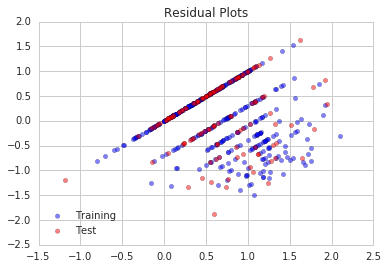

In [178]:
X = df_transformed.drop('noms_adj', 1)
X['Intercept'] = 1
y = df_transformed['noms_adj']

results = runModel(X,y)

results[0].summary()

In [179]:
final = archived_df.merge(results[1])

In [180]:
final['noms'] = final['noms'].astype('float64')
final['error'] = final['predicted_noms'] - final['noms']
final['sq_error'] = final['error']**2
final['opening_weekend_gross'] = np.e**final['opening_weekend_gross']

In [186]:
def top(df, asc=True):
    '''
    
    '''
    df = df.sort_values(by='sq_error', ascending=asc)
    return df[['title', 'director',  'noms', 'predicted_noms', 'error']]
#     return df[['title', 'director',  'noms', 'predicted_noms', 'error', 'prev_noms', 'opening_weekend_gross', 'genre',\
#            'rating', 'season', 'metascore', 'tomato_user_meter']]

### When does the model make good predictions?

Good predictions tend to be closer to average nominations (~2 nominations)

In [193]:
top(final).query('noms > 2').head(10)

,title,director,noms,predicted_noms,error
9,Harry Potter and the Sorcerer's Stone,Chris Columbus,3.0,2.787733,-0.212267
64,The Diving Bell and the Butterfly,Julian Schnabel,4.0,3.753661,-0.246339
42,Apocalypto,Mel Gibson,3.0,2.579791,-0.420209
100,Django Unchained,Quentin Tarantino,5.0,4.572793,-0.427207
54,Little Children,Todd Field,3.0,2.476936,-0.523064
58,The Bourne Ultimatum,Paul Greengrass,3.0,3.537331,0.537331
5,Billy Elliot,Stephen Daldry,3.0,2.400002,-0.599998
127,The Martian,Ridley Scott,7.0,5.992780,-1.007220
70,Changeling,Clint Eastwood,3.0,1.879060,-1.120940
35,War of the Worlds,Steven Spielberg,3.0,1.874570,-1.125430


### When does the model make bad predictions?

Bad predictions tend to be much higher than the average nominations

In [191]:
top(final, False).head(10)

,title,director,noms,predicted_noms,error
1,Gladiator,Ridley Scott,12.0,1.820891,-10.179109
84,The King's Speech,Tom Hooper,12.0,3.445215,-8.554785
77,Inglourious Basterds,Quentin Tarantino,8.0,2.091916,-5.908084
95,Hugo,Martin Scorsese,11.0,5.205705,-5.794295
10,A Beautiful Mind,Ron Howard,8.0,2.877383,-5.122617
51,Babel,Alejandro González Iñárritu,7.0,2.147691,-4.852309
61,There Will Be Blood,Paul Thomas Anderson,8.0,3.576361,-4.423639
59,No Country for Old Men,Ethan CoenJoel Coen,8.0,3.748404,-4.251596
26,Frida,Julie Taymor,6.0,1.752689,-4.247311
29,Cold Mountain,Anthony Minghella,7.0,2.774099,-4.225901


## Model tends to overpredict number of Oscar nominations

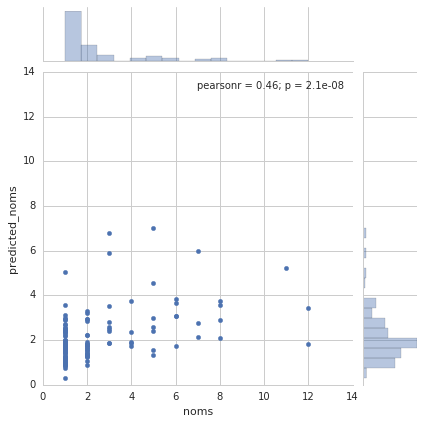

In [201]:
sns.jointplot(x='noms', y='predicted_noms', data=final, xlim=(0,14), ylim=(0,14))

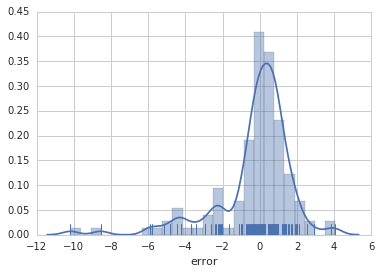

In [207]:
sns.distplot(final['error'], rug=True)

# Future steps to improve the analysis

- Better understand why model over/under-predicts
- Focus analysis on subset of Oscar nominations to avoid differences in categories (e.g., Best Picture vs. Best Score)
- Additional data sources to incorporate
    - Other movie award nominations/wins data (e.g., Golden Globes)
    - Additional historical Oscar nominations/wins for full cast
    - Social media trends
    - Other Oscar prediction analyses
    - More robust Budget data

---

# Appendix 


## Date sources used

- Box Office Mojo for base movie data and Oscar nomination data
- Online Movie Database (OMDB) for Metacritic, Rotten Tomatoes, and IMDB rating data

## Tools used


## Key takeaways

- Keep it focused, especially given the time constraints
- Look for ways to simplify (using a dictionary to map values instead of more automated regex or other techniques)
